In [11]:
import pandas as pd
import numpy as np

In [12]:
filename = "/home/nicolagp/repos/learner-performance-prediction/data/2015_CN_AZUL/preprocessed_data_test.csv"
df = pd.read_csv(filename, delimiter="\t")
df.head()

,user_id,item_id,timestamp,correct,skill_id,DKT2
0,27137,1,0,1,0,0.547829
1,27137,16,0,0,0,0.139495
2,27137,27,0,0,0,0.490726
3,27137,33,0,1,0,0.658095
4,27137,13,0,1,0,0.363106


# Defining Influence
According to Deep Knowledge Tracing, we can define an influence $J_{i,j}$ to every pair of exercises $i, j$:

$$J_{i,j} = \frac{y(i|j)}{\sum_{k} y(i|k)}$$

# Calculating influences

In [76]:
def y(i, j):
    """
    returns y(i|j), the assigned probability of getting i right, given that got j right
    """    
    # students who answered j correctly
    given_j = df.loc[(df["item_id"]==j) & (df["correct"]== 1)]["user_id"].values
    
    # mean of assigned probability of getting i correct
    return df.loc[(df["user_id"].isin(given_j)) & (df["item_id"]==i)]["DKT2"].mean()

def influence1(i, j):
    """
    returns J_i,j, defined above
    """
    return y(i,j) / sum([y(i,k) for k in range(1, 46)])

def get_pairs1(n):
    """
    return an nxn matrix of all pairs of questions 1...n
    """
    pairs = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            pairs[i,j] = influence1(i+1,j+1)
    return pairs

In [111]:
def get_Ycol(j):
    # students who answered j correctly
    given_j = df.loc[(df["item_id"]==j) & (df["correct"]== 1)]["user_id"].values
    a = df.loc[(df["user_id"].isin(given_j))].groupby("item_id")["DKT2"].mean()
    return a

def get_Y():
    """
    returns a matrix of Y_i,j = y(i|j) for i,j in 1...n
    """
    Y = np.zeros((45,45))
    for j in range(45):
        Y[:,j] = get_Ycol(j+1)
    return Y
    
def get_pairs2(n):
    """
    return an nxn matrix of all pairs of questions 1...n
    """
    Y = get_Y()
    pairs = np.zeros((n, n))
    rowsums = Y.sum(axis=1)
    for i in range(n):
        for j in range(n):
            pairs[i,j] = Y[i,j]/rowsums[i]
    return pairs

In [122]:
%timeit get_pairs1(45)

11min 31s ± 1min 24s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
%timeit get_pairs2(45)

580 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [125]:
print("get_pairs2 is {}x faster than get_pairs1".format(round(11.5*60/0.580)))

get_pairs2 is 1190x faster than get_pairs1


### Calculating influences over the possible pairs

In [105]:
%timeit influence(1,2)

404 ms ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
pairs_10 = np.zeros((10,10))
count = 0
total = 10*10
for i in range(10):
    for j in range(10):
        if count % 20 == 0:
            print("Calculated {}/{} pairs".format(count, total))
        pairs_10[i,j] = influence(i+1,j+1)
        count += 1

Calculated 0/100 pairs
Calculated 20/100 pairs
Calculated 40/100 pairs
Calculated 60/100 pairs
Calculated 80/100 pairs


In [109]:
pairs = np.zeros((45, 45))
count = 0
total = 45*45
for i in range(45):
    for j in range(45):
        if count % 20 == 0:
            print("Calculated {}/{} pairs".format(count, total))
        pairs[i,j] = influence(i+1,j+1)
        count += 1

Calculated 0/2025 pairs
Calculated 20/2025 pairs
Calculated 40/2025 pairs
Calculated 60/2025 pairs
Calculated 80/2025 pairs
Calculated 100/2025 pairs
Calculated 120/2025 pairs
Calculated 140/2025 pairs
Calculated 160/2025 pairs
Calculated 180/2025 pairs
Calculated 200/2025 pairs
Calculated 220/2025 pairs
Calculated 240/2025 pairs
Calculated 260/2025 pairs
Calculated 280/2025 pairs
Calculated 300/2025 pairs
Calculated 320/2025 pairs
Calculated 340/2025 pairs
Calculated 360/2025 pairs
Calculated 380/2025 pairs
Calculated 400/2025 pairs
Calculated 420/2025 pairs
Calculated 440/2025 pairs
Calculated 460/2025 pairs
Calculated 480/2025 pairs
Calculated 500/2025 pairs
Calculated 520/2025 pairs
Calculated 540/2025 pairs
Calculated 560/2025 pairs
Calculated 580/2025 pairs
Calculated 600/2025 pairs
Calculated 620/2025 pairs
Calculated 640/2025 pairs
Calculated 660/2025 pairs
Calculated 680/2025 pairs
Calculated 700/2025 pairs
Calculated 720/2025 pairs
Calculated 740/2025 pairs
Calculated 760/202

In [112]:
# save pairs object
import pickle
pickle.dump(pairs, open("influence_pairs.pkl", "wb"))

### Visualizing pairs

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

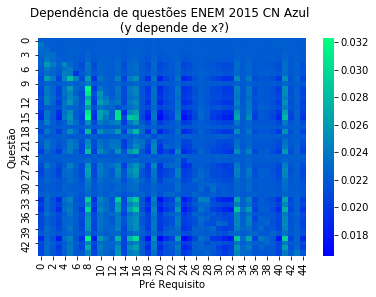

In [122]:
ax = sns.heatmap(pairs, cmap="winter")
plt.title("Dependência de questões ENEM 2015 CN Azul \n (y depende de x?)")
plt.xlabel("Pré Requisito")
plt.ylabel("Questão")
plt.savefig("influence_pairs.jpg", dpi=400)
plt.show()